Poems analysis
----

In this notebook we will use Minisom to cluster poems from three different authors.

Requirements:
- Glove vectors, https://nlp.stanford.edu/projects/glove/ glove.6B.50d.txt
- Beautiful soup
- An internet connection as the poems will be downlaoded from www.poemhunter.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Retrieving the poems from poemhunter.com
----

***Warning***: this may take a while.

In [32]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

#-------------------------------------------------------------------------------

def scrape_poem(poem_url):
    poem_page = urlopen(poem_url).read()
    soup = BeautifulSoup(poem_page)
    poem = ''
    poem_string = soup.find_all("div", 
                                {"class": "KonaBody" })[0].find_all('p')[0]
    poem_string = str(poem_string)[3:-4].replace('<br/>', ' ')
    return poem_string

def scrape_poems_index(poems_index_url):
    poems_index = urlopen(poems_index_url).read()    
    soup = BeautifulSoup(poems_index)
    pages = soup.find_all("div", {"class": "pagination"})
    if len(pages) == 0:
        return get_all_links(soup)
    
    pages = pages[0].find_all('a')
    result = {}
    cnt = 0
    for page in pages:
        page_link = 'https://www.poemhunter.com/'+page['href']
        page_soup = BeautifulSoup(urlopen(page_link))
        result.update(get_all_links(page_soup))
    return result

def get_all_links(page_soup):
    result = {}
    for link in page_soup.find_all('table')[0].find_all('a'):
        result[link.text] = 'https://www.poemhunter.com/'+link['href']
    return result

def get_poems(poems_index, max_poems=None):
    poems = {}
    for i, (title, poem_url) in enumerate(poems_index.items()):
        print('fetching', title, '...')
        try:
            poems[title] = scrape_poem(poem_url)
            print('OK')
        except:
            print('impossible to fetch')
        if i == max_poems-1:
            return poems
    return poems

In [36]:
poems_index_neruda = scrape_poems_index('https://www.poemhunter.com/pablo-neruda/poems/')
poems_index_bukowski = scrape_poems_index('https://www.poemhunter.com/charles-bukowski/poems/')
poems_index_poe = scrape_poems_index('https://www.poemhunter.com/edgar-allan-poe/poems/')

In [37]:
poems_neruda = get_poems(poems_index_neruda, max_poems=60)
poems_bukowski = get_poems(poems_index_bukowski, max_poems=60)
poems_poe = get_poems(poems_index_poe, max_poems=60)

fetching Sonnet Lxxiii: Maybe You'Ll Remember ...
OK
fetching From The Heights Of Maccho Picchu ...
OK
fetching Entrance Of The Rivers ...
OK
fetching Finale ...
OK
fetching Soneto Xvii ...
OK
fetching Triangles ...
OK
fetching The Weary One ...
OK
fetching Sonnet Xxxiv (You Are The Daughter Of The Sea) ...
OK
fetching Poesia ...
OK
fetching The Tree Is Here, Still, In Pure Stone ...
OK
fetching Sonnet Ix: There Where The Waves Shatter ...
OK
fetching Sonnet Lxxxi: Rest With Your Dream Inside My Dream ...
OK
fetching Magellanic Penguin ...
OK
fetching Fleas Interest Me So Much ...
OK
fetching The People ...
OK
fetching Song Of Despair ...
OK
fetching Ode To The Artichoke ...
OK
fetching Sonnet Viii ...
OK
fetching Enigma With Flower ...
OK
fetching Ode To Clothes ...
OK
fetching Sonnet Xxvii: Naked You Are As Simple As One Of Your Hands ...
OK
fetching Some Beasts ...
OK
fetching Poet's Obligation ...
OK
fetching Lost In The Forest ...
OK
fetching The Queen ...
OK
fetching ‘march Days 

In [38]:
all_poems = [poems_neruda, poems_bukowski, poems_poe]
titles = np.concatenate([list(title_list.keys()) for title_list in all_poems])
y = np.concatenate([[i]*len(p) for i, p in enumerate(all_poems)])
all_poems = np.concatenate([list(p.values()) for p in all_poems])

Preprocessing of the poems
---

The following operations are applied:

1. stopwords removal
2. tokenization
3. conversion in Glove vectors

In [39]:
from string import punctuation
import stop_words
stopwords = stop_words.get_stop_words('english')

def tokenize_poem(poem):
    poem = poem.lower().replace('\n', ' ')
    for sign in punctuation:
        poem = poem.replace(sign, '')
    tokens = poem.split()
    tokens = [t for t in tokens if t not in stopwords and t != '']
    return tokens

tokenized_poems = [tokenize_poem(poem) for poem in all_poems]

In [40]:
def gimme_glove():
    with open('glove.6B/glove.6B.50d.txt') as glove_raw:
        for line in glove_raw.readlines():
            splitted = line.split(' ')
            yield splitted[0], np.array(splitted[1:], dtype=np.float)
            
glove = {w: x for w, x in gimme_glove()}

def closest_word(in_vector, top_n=1):
    vectors = glove.values()
    idx = np.argsort([np.linalg.norm(vec-in_vector) for vec in vectors])
    return [glove.keys()[i] for i in idx[:top_n]]

In [41]:
def poem_to_vec(tokens):
    words = [w for w in np.unique(tokens) if w in glove]
    return np.array([glove[w] for w in words])

W = [poem_to_vec(tokenized).mean(axis=0) for tokenized in tokenized_poems]
W = np.array(W)

Running minisom and visualizing the result
----
***Warning***: This may take a while.

In [43]:
from minisom import MiniSom
map_dim = 16
som = MiniSom(map_dim, map_dim, 50, sigma=1.0, random_seed=1)
#som.random_weights_init(W)
som.train_batch(W, num_iteration=len(W)*500, verbose=True)

 [   165 / 90000 ]   0% - 815.67 it/s - 0:01:50 left 

 [   335 / 90000 ]   0% - 830.83 it/s - 0:01:47 left 

 [   508 / 90000 ]   1% - 840.79 it/s - 0:01:46 left 

 [   685 / 90000 ]   1% - 847.71 it/s - 0:01:45 left 

 [   858 / 90000 ]   1% - 850.15 it/s - 0:01:44 left 

 [  1033 / 90000 ]   1% - 852.29 it/s - 0:01:44 left 

 [  1205 / 90000 ]   1% - 852.35 it/s - 0:01:44 left 

 [  1380 / 90000 ]   2% - 853.81 it/s - 0:01:43 left 

 [  1546 / 90000 ]   2% - 850.43 it/s - 0:01:44 left 

 [  1722 / 90000 ]   2% - 852.12 it/s - 0:01:43 left 

 [  1895 / 90000 ]   2% - 852.49 it/s - 0:01:43 left 

 [  2069 / 90000 ]   2% - 853.29 it/s - 0:01:43 left 

 [  2237 / 90000 ]   2% - 851.99 it/s - 0:01:43 left 

 [  2411 / 90000 ]   3% - 852.50 it/s - 0:01:42 left 

 [  2584 / 90000 ]   3% - 852.52 it/s - 0:01:42 left 

 [  2760 / 90000 ]   3% - 853.64 it/s - 0:01:42 left 

 [  2933 / 90000 ]   3% - 853.60 it/s - 0:01:42 left 

 [  3103 / 90000 ]   3% - 853.03 it/s - 0:01:41 left 

 [  3285 / 90000 ]   4% - 855.20 it/s - 0:01:41 left 

 [  3457 / 90000 ]   4% - 855.09 it/s - 0:01:41 left 

 [  3631 / 90000 ]   4% - 855.49 it/s - 0:01:40 left 

 [  3801 / 90000 ]   4% - 854.86 it/s - 0:01:40 left 

 [  3976 / 90000 ]   4% - 855.32 it/s - 0:01:40 left 

 [  4155 / 90000 ]   5% - 856.63 it/s - 0:01:40 left 

 [  4330 / 90000 ]   5% - 856.98 it/s - 0:01:39 left 

 [  4505 / 90000 ]   5% - 857.41 it/s - 0:01:39 left 

 [  4676 / 90000 ]   5% - 857.10 it/s - 0:01:39 left 

 [  4853 / 90000 ]   5% - 858.01 it/s - 0:01:39 left 

 [  5025 / 90000 ]   6% - 857.59 it/s - 0:01:39 left 

 [  5196 / 90000 ]   6% - 857.19 it/s - 0:01:38 left 

 [  5375 / 90000 ]   6% - 858.22 it/s - 0:01:38 left 

 [  5551 / 90000 ]   6% - 858.60 it/s - 0:01:38 left 

 [  5724 / 90000 ]   6% - 858.54 it/s - 0:01:38 left 

 [  5896 / 90000 ]   7% - 858.43 it/s - 0:01:37 left 

 [  6062 / 90000 ]   7% - 857.42 it/s - 0:01:37 left 

 [  6234 / 90000 ]   7% - 857.36 it/s - 0:01:37 left 

 [  6408 / 90000 ]   7% - 857.57 it/s - 0:01:37 left 

 [  6584 / 90000 ]   7% - 857.87 it/s - 0:01:37 left 

 [  6759 / 90000 ]   8% - 858.06 it/s - 0:01:37 left 

 [  6931 / 90000 ]   8% - 857.97 it/s - 0:01:36 left 

 [  7099 / 90000 ]   8% - 857.17 it/s - 0:01:36 left 

 [  7271 / 90000 ]   8% - 856.99 it/s - 0:01:36 left 

 [  7447 / 90000 ]   8% - 857.26 it/s - 0:01:36 left 

 [  7621 / 90000 ]   8% - 857.35 it/s - 0:01:36 left 

 [  7794 / 90000 ]   9% - 857.34 it/s - 0:01:35 left 

 [  7969 / 90000 ]   9% - 857.45 it/s - 0:01:35 left 

 [  8145 / 90000 ]   9% - 857.60 it/s - 0:01:35 left 

 [  8320 / 90000 ]   9% - 857.80 it/s - 0:01:35 left 

 [  8498 / 90000 ]   9% - 858.27 it/s - 0:01:34 left 

 [  8669 / 90000 ]  10% - 857.96 it/s - 0:01:34 left 

 [  8847 / 90000 ]  10% - 858.50 it/s - 0:01:34 left 

 [  9023 / 90000 ]  10% - 858.63 it/s - 0:01:34 left 

 [  9198 / 90000 ]  10% - 858.73 it/s - 0:01:34 left 

 [  9371 / 90000 ]  10% - 858.70 it/s - 0:01:33 left 

 [  9548 / 90000 ]  11% - 859.07 it/s - 0:01:33 left 

 [  9722 / 90000 ]  11% - 859.07 it/s - 0:01:33 left 

 [  9895 / 90000 ]  11% - 859.04 it/s - 0:01:33 left 

 [ 10067 / 90000 ]  11% - 858.95 it/s - 0:01:33 left 

 [ 10236 / 90000 ]  11% - 858.57 it/s - 0:01:32 left 

 [ 10412 / 90000 ]  12% - 858.78 it/s - 0:01:32 left 

 [ 10584 / 90000 ]  12% - 858.73 it/s - 0:01:32 left 

 [ 10753 / 90000 ]  12% - 858.32 it/s - 0:01:32 left 

 [ 10928 / 90000 ]  12% - 858.50 it/s - 0:01:32 left 

 [ 11103 / 90000 ]  12% - 858.58 it/s - 0:01:31 left 

 [ 11279 / 90000 ]  13% - 858.82 it/s - 0:01:31 left 

 [ 11453 / 90000 ]  13% - 858.86 it/s - 0:01:31 left 

 [ 11625 / 90000 ]  13% - 858.74 it/s - 0:01:31 left 

 [ 11795 / 90000 ]  13% - 858.51 it/s - 0:01:31 left 

 [ 11973 / 90000 ]  13% - 858.87 it/s - 0:01:30 left 

 [ 12149 / 90000 ]  13% - 859.07 it/s - 0:01:30 left 

 [ 12326 / 90000 ]  14% - 859.30 it/s - 0:01:30 left 

 [ 12499 / 90000 ]  14% - 859.27 it/s - 0:01:30 left 

 [ 12676 / 90000 ]  14% - 859.44 it/s - 0:01:29 left 

 [ 12855 / 90000 ]  14% - 859.78 it/s - 0:01:29 left 

 [ 13025 / 90000 ]  14% - 859.54 it/s - 0:01:29 left 

 [ 13208 / 90000 ]  15% - 860.07 it/s - 0:01:29 left 

 [ 13382 / 90000 ]  15% - 860.10 it/s - 0:01:29 left 

 [ 13561 / 90000 ]  15% - 860.47 it/s - 0:01:28 left 

 [ 13728 / 90000 ]  15% - 860.04 it/s - 0:01:28 left 

 [ 13900 / 90000 ]  15% - 859.94 it/s - 0:01:28 left 

 [ 14076 / 90000 ]  16% - 860.01 it/s - 0:01:28 left 

 [ 14252 / 90000 ]  16% - 860.16 it/s - 0:01:28 left 

 [ 14424 / 90000 ]  16% - 859.98 it/s - 0:01:27 left 

 [ 14599 / 90000 ]  16% - 860.08 it/s - 0:01:27 left 

 [ 14773 / 90000 ]  16% - 860.04 it/s - 0:01:27 left 

 [ 14948 / 90000 ]  17% - 860.15 it/s - 0:01:27 left 

 [ 15119 / 90000 ]  17% - 860.01 it/s - 0:01:27 left 

 [ 15283 / 90000 ]  17% - 859.44 it/s - 0:01:26 left 

 [ 15451 / 90000 ]  17% - 859.09 it/s - 0:01:26 left 

 [ 15629 / 90000 ]  17% - 859.28 it/s - 0:01:26 left 

 [ 15804 / 90000 ]  18% - 859.33 it/s - 0:01:26 left 

 [ 15978 / 90000 ]  18% - 859.30 it/s - 0:01:26 left 

 [ 16156 / 90000 ]  18% - 859.50 it/s - 0:01:25 left 

 [ 16337 / 90000 ]  18% - 859.82 it/s - 0:01:25 left 

 [ 16511 / 90000 ]  18% - 859.84 it/s - 0:01:25 left 

 [ 16663 / 90000 ]  19% - 858.73 it/s - 0:01:25 left 

 [ 16838 / 90000 ]  19% - 858.81 it/s - 0:01:25 left 

 [ 17014 / 90000 ]  19% - 858.95 it/s - 0:01:24 left 

 [ 17183 / 90000 ]  19% - 858.69 it/s - 0:01:24 left 

 [ 17359 / 90000 ]  19% - 858.80 it/s - 0:01:24 left 

 [ 17523 / 90000 ]  19% - 858.35 it/s - 0:01:24 left 

 [ 17690 / 90000 ]  20% - 857.97 it/s - 0:01:24 left 

 [ 17867 / 90000 ]  20% - 858.15 it/s - 0:01:24 left 

 [ 18048 / 90000 ]  20% - 858.50 it/s - 0:01:23 left 

 [ 18221 / 90000 ]  20% - 858.50 it/s - 0:01:23 left 

 [ 18397 / 90000 ]  20% - 858.62 it/s - 0:01:23 left 

 [ 18575 / 90000 ]  21% - 858.83 it/s - 0:01:23 left 

 [ 18743 / 90000 ]  21% - 858.59 it/s - 0:01:22 left 

 [ 18910 / 90000 ]  21% - 858.23 it/s - 0:01:22 left 

 [ 19089 / 90000 ]  21% - 858.44 it/s - 0:01:22 left 

 [ 19262 / 90000 ]  21% - 858.41 it/s - 0:01:22 left 

 [ 19437 / 90000 ]  22% - 858.44 it/s - 0:01:22 left 

 [ 19608 / 90000 ]  22% - 858.37 it/s - 0:01:22 left 

 [ 19782 / 90000 ]  22% - 858.29 it/s - 0:01:21 left 

 [ 19956 / 90000 ]  22% - 858.30 it/s - 0:01:21 left 

 [ 20127 / 90000 ]  22% - 858.20 it/s - 0:01:21 left 

 [ 20288 / 90000 ]  23% - 857.68 it/s - 0:01:21 left 

 [ 20459 / 90000 ]  23% - 857.61 it/s - 0:01:21 left 

 [ 20628 / 90000 ]  23% - 857.41 it/s - 0:01:20 left 

 [ 20796 / 90000 ]  23% - 857.14 it/s - 0:01:20 left 

 [ 20968 / 90000 ]  23% - 857.10 it/s - 0:01:20 left 

 [ 21140 / 90000 ]  23% - 857.05 it/s - 0:01:20 left 

 [ 21311 / 90000 ]  24% - 856.96 it/s - 0:01:20 left 

 [ 21482 / 90000 ]  24% - 856.88 it/s - 0:01:19 left 

 [ 21658 / 90000 ]  24% - 856.99 it/s - 0:01:19 left 

 [ 21833 / 90000 ]  24% - 857.07 it/s - 0:01:19 left 

 [ 22003 / 90000 ]  24% - 856.96 it/s - 0:01:19 left 

 [ 90000 / 90000 ] 100% - 838.92 it/s - 0:00:00 left  - quantization error: 0.29608424987606785


In [44]:
author_to_color = {0: 'chocolate',
                   1: 'steelblue',
                   2: 'dimgray'}
color = [author_to_color[yy] for yy in y]

[]

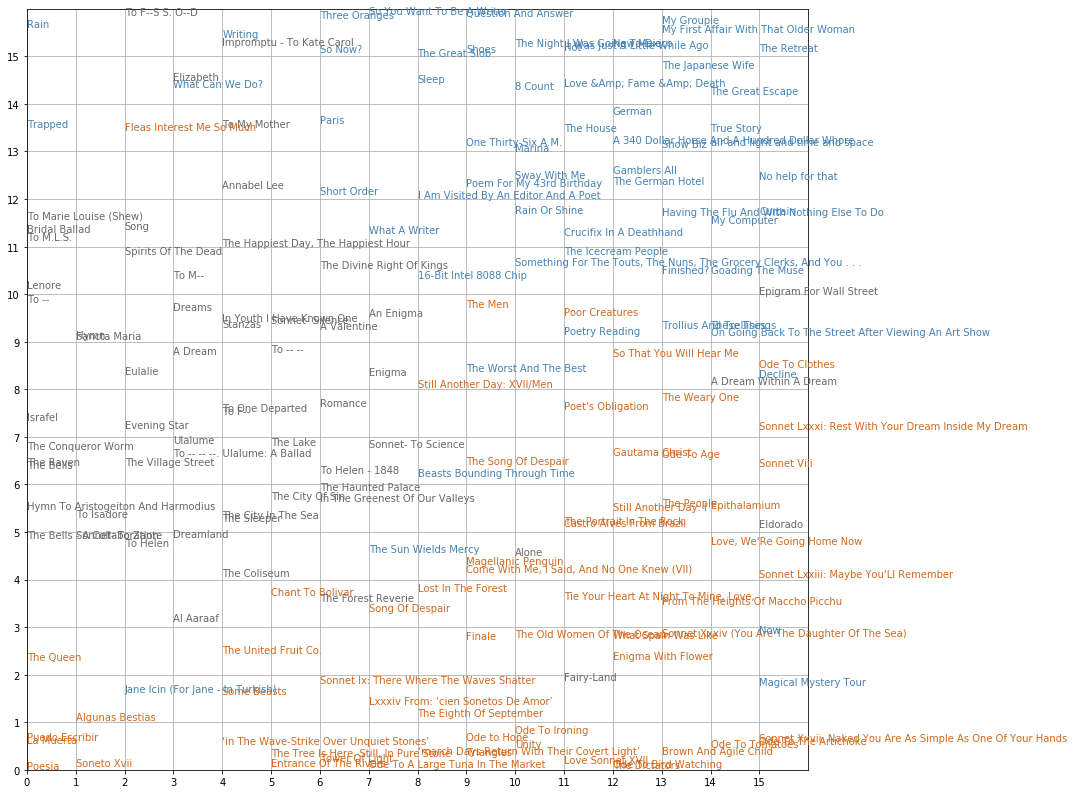

In [45]:
plt.figure(figsize=(14, 14))
for i, (t, c, vec) in enumerate(zip(titles, color, W)):
    winnin_position = som.winner(vec)
    plt.text(winnin_position[0], 
             winnin_position[1]+np.random.rand()*.9, 
             t,
             color=c)

plt.xticks(range(map_dim))
plt.yticks(range(map_dim))
plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()